## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2021-12-20 07:14:10--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2021-12-20 07:14:10 (5.78 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')
print(len(text))

OK!
100225


### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-12-19 20:42:54--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2021-12-19 20:42:54 (8.60 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {tokens[i]: i for i in range(len(tokens))}

# dict <char>:<index>
# Your great code here
idx_to_token = {i: tokens[i] for i in range(len(tokens))}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
device = torch.device('cuda:0')
class CharRNN(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=256):
        super(self.__class__,self).__init__()
        self.num_tokens = num_tokens
        self.embedding = nn.Linear(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, num_layers=3, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
      # embedding + one-hot encoding
        x_emb = self.embedding(torch.tensor(np.eye(self.num_tokens)[x]).float().to(device))
        output, h_next = self.rnn(x_emb.to(device))
        next_logits = self.rnn_to_logits(output)
        return next_logits

In [ ]:
net = CharRNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

In [ ]:
def to_matrix(inds, pad=token_to_idx[' '], dtype='int64', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    return_ix = np.zeros(inds.shape, dtype) + pad

    for i in range(len(inds)):
        text_line = [text[inds[i][j]] for j in range(len(inds[i]))]
        line_ix = [token_to_idx[c] for c in text_line]
        return_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        return_ix = np.transpose(return_ix)

    return return_ix

Plot the loss function (axis X: number of epochs, axis Y: loss function).

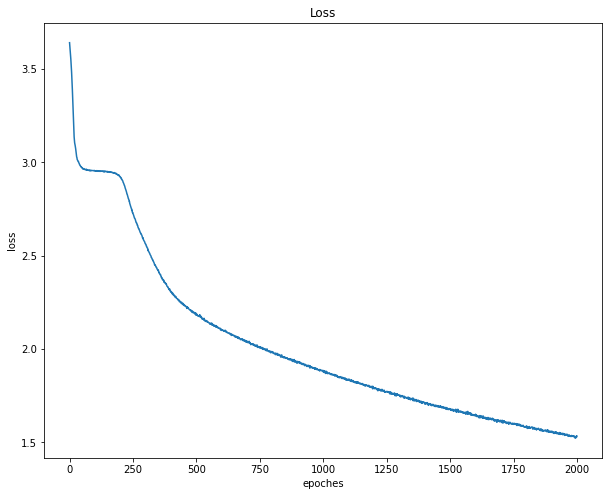

In [ ]:
from IPython.display import clear_output
from random import sample

num_epoches = 2000
batch_size = 1000 # number of samples in batch
batch_num = 400 # length of substrings taken as samples
tokens_num = len(tokens)

loss_history = []
net.train()
for i in range(num_epoches):
    start_inds = np.random.choice(len(text) - batch_num + 1, size=batch_size)
    batch_ix = to_matrix(np.arange(batch_num) + start_inds[:, None])
    batch_ix = np.array(batch_ix)

    optimizer.zero_grad()

    predictions = net(batch_ix[:, :-1])
    y = torch.tensor(batch_ix[:, 1:]).to(device)

    loss = loss_func(predictions.view(-1, tokens_num), y.flatten())
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.detach().cpu().data)
    
    # Plot
    clear_output(wait=True)
    plt.figure(figsize=(10,8))
    plt.plot(loss_history)
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoches')
    plt.show()

In [ ]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=batch_num, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    char_rnn.eval()
    x_sequence = np.array([token_to_idx[token] for token in seed_phrase])
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out = char_rnn(x_sequence.cpu().data.numpy())
        # Be really careful here with the model output
        # We need info only for the new (generated) letter
        p_next = F.softmax(out[0, -1] / temperature, dim=-1).cpu().data.numpy()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])


In [ ]:
# An example of generated text.
print(generate_sample(net, max_length=500, temperature=0.2))

 hellow in the self thee my love,
  and the sunse shall the will be the seem
  the self the seem the world the some to me prease;
  and the will the will the will the will stay,
  and the will not so the will the self in thee,
    the love thee thou art the were the self thee,
    then the will me the sumes the world so mend,
  and the seem and the worth the with the stall,
  when i am the will the prood to thee thee,
    the beauty the seem thee and the store,
    then the worth the will the wo


In [ ]:
print(generate_sample(net, max_length=500, temperature=0.02))

 hellow in the seem thee thee thee thee,
    then the will the will the will the see thee,
    the will the will the will the will the see,
    then the will the will the will the see thee,
    then the will the will the will the see thee,
    then the will the will the will the see thee,
    then the will the will the will the see thee,
    then the will the will the will the see thee,
    then the will the will the will the see thee,
    then the will the will the will the see thee,
    then t


In [ ]:
print(generate_sample(net, max_length=500, temperature=2))

 helloug
- ,- tle pbejnct shy tlanfint a mifprbthant
  gndess ewelw'd's hbtald knam -jaksailellx,,;
  matiois,(bey blpolxsind, ix?, muliw ifmetovy hefinl,y flooe,
  goo! whome lugfn  aed-oip mrscottuy ave
  betups batardj tromy,
  dach: whory utiin,sb srail, -(wultaineg otapity

  nachx:
  rakpwndw, teefpavtk be trm)iot misincy't!!
  ro'l
  lin': icwer atwqator torow,
  now, sevememye, nos gnmake: id ifroftitot:
  what hyom, dot euty pfainxe,'; boagyt
  gelait,? hit hecornm'soutsmuqtikei!
  that


In [ ]:
# As we can see, with too low temperature the model chooses most probable letters and, as a result, text is repetitive. 
# With two high temperature, choice of next letter is too chaotic (almost random), and we can hardly find a sensible word.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
device = torch.device('cuda:0')
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=256):
        super(self.__class__,self).__init__()
        self.num_tokens = num_tokens
        self.embedding = nn.Linear(num_tokens, embedding_size)
        self.rnn = nn.LSTM(embedding_size, rnn_num_units, num_layers=3, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
      # embedding + one-hot encoding
        x_emb = self.embedding(torch.tensor(np.eye(self.num_tokens)[x]).float().to(device))
        output, h_next = self.rnn(x_emb.to(device))
        next_logits = self.rnn_to_logits(output)
        return next_logits

net = CharLSTM().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

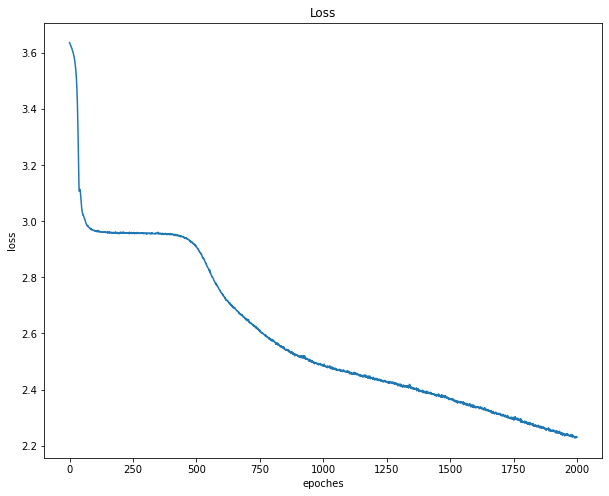

In [ ]:
from IPython.display import clear_output
from random import sample

num_epoches = 2000
batch_size = 1000 # number of samples in batch
batch_num = 400 # length of substrings taken as samples
tokens_num = len(tokens)

loss_history = []
net.train()
for i in range(num_epoches):
    start_inds = np.random.choice(len(text) - batch_num + 1, size=batch_size)
    batch_ix = to_matrix(np.arange(batch_num) + start_inds[:, None])
    batch_ix = np.array(batch_ix)

    optimizer.zero_grad()

    predictions = net(batch_ix[:, :-1])
    y = torch.tensor(batch_ix[:, 1:]).to(device)

    loss = loss_func(predictions.view(-1, tokens_num), y.flatten())
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.detach().cpu().data)
    torch.save(net.state_dict(), '/content/drive/MyDrive/ML&Stats labs/lstm_net.pth')
    
    # Plot
    clear_output(wait=True)
    plt.figure(figsize=(10,8))
    plt.plot(loss_history)
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoches')
    plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
temperature = [0.1, 0.2, 0.5, 1.0, 2.0]
for t in temperature:
  print("temperature={}".format(t))
  print(generate_sample(net, max_length=300, temperature=t))

temperature=0.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


 hellor thee thee thee thee thee thee thee thee soree,
  and the thee thee the the the the the thee sore,
  th the thee thee thee the than thee thee thee tore,
  the thee the thee thee the thee the thee thee thee,
  th the the thee the the thee the thee ton thee sore,
  the thee the the thee the the
temperature=0.2
 hellon the thee the the thee sore seate,
    the than the the the thee than thee tore thar seeee,
  th the thee sole thar thee tout thur the thee tore,
  thon the the the thee the thar thee thor thee thee,
  thou the th the thee thee than thee the sore seee,
    the the the thee thee the their sone
temperature=0.5
 hellon here thee is thase son whers dinet

    the as meires ooe this murt theoe te bores.
    thil touse theor cean thar sher mon thoee,
  thee in ther to thot mill tor tomh on oneed,
    th any tere soath sall the dov toe dhany sores,
  thon eeadt te mirirt pos tore ceanl,
  thir thot hod sowes o
temperature=1.0
 hellod moyee nonl,
  oon in iss foad, euflh to t

In [ ]:
# Conclusions are the same as in previous part.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/ML&Stats labs/lstm_net_.pth')

In [ ]:
load_net = CharLSTM().to(device)
load_net.load_state_dict(torch.load('/content/drive/MyDrive/ML&Stats labs/lstm_net_.pth'))
print(generate_sample(load_net, max_length=500, temperature=0.6))

 hellor teee ard with sore;
  o siv sh and dass bov vol late are leeee,
  wh oot an tore thur tat th thas af thee yhe tind weine,
    noin shele thore shee to shy th the toeos in seee,
  the srot sone mey shor tey so dour that bny gteor

   ir buvt mh thee thee thealey tit le banlet thov,
   ns thone'n th seat hut if wh semr core dhee, theee mosh tonineed bile seame:
  than in shuus do sewett mritees hat tore mat toe thee

  thor thar thd annet aet bote if wher wole:
  th tham weat fovin thee t 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)